# Implementation

## Data Preprocessing

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [2]:
dataset_train = pd.read_csv('Smart_Irrigation_Train.csv')
print(dataset_train.head())

               date  Soil Moisture Resistance (Ohm)  \
0  01-03-2023 00:00                             638   
1  01-03-2023 00:15                             522   
2  01-03-2023 00:30                             741   
3  01-03-2023 00:45                             798   
4  01-03-2023 01:00                             690   

   Ambient Temperature (deg. C)  Atmospheric Humidity (%)  \
0                          30.6                        60   
1                          30.6                        37   
2                          30.6                        40   
3                          30.6                        40   
4                          30.6                        67   

   DC Water pump Status  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  


### Convert Date and Time to recognizable format

In [3]:
dataset_train['date'] = pd.to_datetime(dataset_train['date'], format='%d-%m-%Y %H:%M')

dataset_train['hour'] = dataset_train['date'].dt.hour
dataset_train['minute'] = dataset_train['date'].dt.minute

dataset_train.drop(columns=['date'], inplace=True)

In [4]:
print(dataset_train)

      Soil Moisture Resistance (Ohm)  Ambient Temperature (deg. C)  \
0                                638                          30.6   
1                                522                          30.6   
2                                741                          30.6   
3                                798                          30.6   
4                                690                          30.6   
...                              ...                           ...   
4315                             502                          30.6   
4316                             497                          33.4   
4317                             523                          31.7   
4318                             540                          30.5   
4319                             466                          32.6   

      Atmospheric Humidity (%)  DC Water pump Status  hour  minute  
0                           60                     1     0       0  
1                    

### Feature Definition and Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
features = ['Soil Moisture Resistance (Ohm)', 'Ambient Temperature (deg. C)', 'Atmospheric Humidity (%)', 'hour', 'minute']
target = 'DC Water pump Status'

In [6]:

scaler = MinMaxScaler()
dataset_train[features] = scaler.fit_transform(dataset_train[features])

In [7]:
print(dataset_train.head())

   Soil Moisture Resistance (Ohm)  Ambient Temperature (deg. C)  \
0                        0.621569                      0.906667   
1                        0.507843                      0.906667   
2                        0.722549                      0.906667   
3                        0.778431                      0.906667   
4                        0.672549                      0.906667   

   Atmospheric Humidity (%)  DC Water pump Status      hour    minute  
0                      0.80                     1  0.000000  0.000000  
1                      0.34                     1  0.000000  0.333333  
2                      0.40                     1  0.000000  0.666667  
3                      0.40                     1  0.000000  1.000000  
4                      0.94                     1  0.043478  0.000000  


### Creating a data structure with 60 timesteps and 1 output

In [8]:
def create_sequences(data, target_col, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  
        y.append(target_col[i + time_steps])  
    return np.array(X), np.array(y).reshape(-1, 1) 


data_values = dataset_train.values  
time_steps = 12

X,y= create_sequences(dataset_train[features].values, dataset_train[target].values, time_steps=time_steps)

In [9]:

print("Input shape:", X.shape) 
print("Target shape:", y.shape)

Input shape: (4308, 12, 5)
Target shape: (4308, 1)


### Import the Test CSV File

In [10]:
test_df = pd.read_csv("Smart_Irrigation_Test.csv")
test_df['date'] = pd.to_datetime(test_df['date'], format='%d-%m-%Y %H:%M')

test_df['hour'] = test_df['date'].dt.hour
test_df['minute'] = test_df['date'].dt.minute

test_df.drop(columns=['date'], inplace=True)


In [11]:
print(test_df.head())

   Soil Moisture Resistance (Ohm)  Ambient Temperature (deg. C)  \
0                             496                          25.0   
1                             497                          30.5   
2                             481                          25.0   
3                             520                          32.9   
4                             465                          30.2   

   Atmospheric Humidity (%)  DC Water pump Status  hour  minute  
0                        34                     0     0       0  
1                        30                     0     0      15  
2                        57                     0     0      30  
3                        50                     1     0      45  
4                        44                     0     1       0  


In [12]:
test_df[features] = scaler.transform(test_df[features])
X_test_seq = np.array(test_df[features])
print("X_test shape after scaling:", X_test_seq.shape)

X_test shape after scaling: (1537, 5)


In [13]:
X_test_seq_reshaped = []
for i in range(len(X_test_seq) - time_steps):
    X_test_seq_reshaped.append(X_test_seq[i:i+time_steps])

X_test_seq_reshaped = np.array(X_test_seq_reshaped)
y_test_seq = test_df[target].values[time_steps:] 

y_test_seq = y_test_seq.reshape(-1, 1)
print("X_test_seq_reshaped shape:", X_test_seq_reshaped.shape)
print("y_test_seq shape:", y_test_seq.shape)

if len(X_test_seq_reshaped) != len(y_test_seq):
    min_length = min(len(X_test_seq_reshaped), len(y_test_seq))
    X_test_seq_reshaped = X_test_seq_reshaped[:min_length]
    y_test_seq = y_test_seq[:min_length]
    
    print("After adjustment:")
    print("X_test_seq_reshaped shape:", X_test_seq_reshaped.shape)
    print("y_test_seq shape:", y_test_seq.shape)

X_test_seq_reshaped shape: (1525, 12, 5)
y_test_seq shape: (1525, 1)


In [14]:
print("Final X_test shape for LSTM:", X_test_seq_reshaped.shape)

Final X_test shape for LSTM: (1525, 12, 5)


## Part 2 - Building and Training the Model

### Importing the Keras libraries and packages

In [15]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Activation

In [16]:
regressor = Sequential()

In [ ]:
regressor.add(Conv1D(filters=64, kernel_size=3, padding='same', input_shape=(X.shape[1], X.shape[2])))
regressor.add(BatchNormalization())
regressor.add(Activation('relu'))
regressor.add(MaxPooling1D(pool_size=2))
regressor.add(Dropout(0.5))

c:\Users\khach\.conda\envs\ml-project-tf-gpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
regressor.add(Conv1D(filters=256, kernel_size=3, padding='same'))
regressor.add(BatchNormalization())
regressor.add(Activation('relu'))
regressor.add(Dropout(0.5))

### Adding the first LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units=150, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),Dropout(0.4))


c:\Users\khach\.conda\envs\ml-project-tf-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Adding a second LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True,dropout=0.4, recurrent_dropout=0.3))

### Adding a third LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 100, return_sequences = True,dropout=0.4, recurrent_dropout=0.5))

### Adding a fourth LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 150,return_sequences = False,dropout=0.4, recurrent_dropout=0.5))

### Adding the output layer

In [23]:
regressor.add(Dense(units = 1,activation='sigmoid'))

### Compiling the RNN

In [24]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
regressor.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [25]:
regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 12, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 6, 150)         │       244,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 300)         │       541,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 6, 150)         │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 75)             │        67,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,226,020 (4.68 MB)

 Trainable params: 1,225,252 (4.67 MB)

 Non-trainable params: 768 (3.00 KB)

### Fitting the RNN to the Training set

In [26]:
regressor.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.6018 - loss: 0.6531
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6890 - loss: 0.5729
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6878 - loss: 0.5563
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7008 - loss: 0.5496
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7099 - loss: 0.5205
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7179 - loss: 0.5166
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7419 - loss: 0.4789
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.7280 - loss: 0.4922
Epoch 9/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.7318 - loss: 0.4913
Epoch 10/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7468 - loss: 0.4577
Epoch 11/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.7553 - loss: 0.4663
Epoch 12/50
135/135 ━━━━━━━━━━━━━━━━━━━━

# Test on the Test Data

In [27]:
test_loss, test_accuracy = regressor.evaluate(X_test_seq_reshaped,y_test_seq)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5730 - loss: 0.6414
Test Accuracy: 0.6839, Test Loss: 0.5162


In [28]:
from sklearn.metrics import classification_report

y_pred = regressor.predict(X_test_seq_reshaped)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test_seq, y_pred_classes))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
              precision    recall  f1-score   support

           0       0.56      0.17      0.26       501
           1       0.70      0.94      0.80      1024

    accuracy                           0.68      1525
   macro avg       0.63      0.55      0.53      1525
weighted avg       0.65      0.68      0.62      1525



[[ 83 418]
 [ 64 960]]


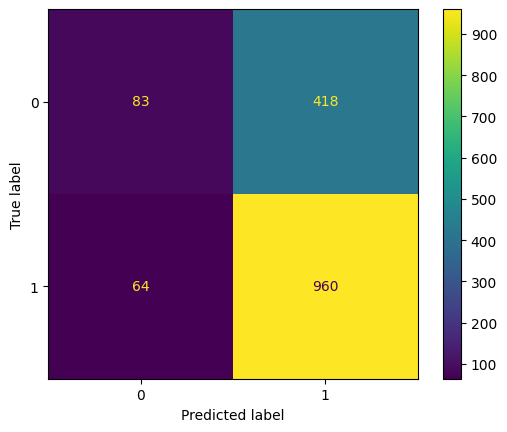

In [29]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_seq, y_pred_classes)
print(cm)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
